In [3]:
import EegFunctions
import importlib
importlib.reload(EegFunctions)
from EegFunctions import *
%matplotlib qt

In [4]:
class Config:
    """Configuration settings for P300 analysis"""
    
    # File paths
    
    DATA_FILE =  r'C:\Users\Keerti\Downloads\MySolution\PlayBooks\data\10_MMN_preprocessed.set'
    RESULTS_DIR = "C:/Users/Keerti/Downloads/MySolution/EEG-ExPy/tests/Analysis/processing_result"
   
    DEVICE = 'unicorn'  # 'muse' or 'unicorn'
    SAMPLING_RATE = 250
    CHANNELS = ['TP9', 'AF7', 'AF8', 'TP10'] if DEVICE == 'muse' else ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
    ANALYSIS_CHANNELS = ['TP9', 'TP10'] if DEVICE == 'muse' else [ 'Pz','Cz']
    
    # Filtering parameters
    HIGH_PASS = 0.1
    LOW_PASS = 30
    NOTCH_FREQ = [60]
  
    FREQ_BANDS = {
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 40)
    }

       # Channels for P300 analysis
    
    # Epoching parameters
    EPOCH_TMIN = -0.1
    EPOCH_TMAX = 0.6
    BASELINE = (-0.1, 0)
    
    # Event codes
    EVENT_DICT = {'standard': 1, 'deviant': 2}

In [5]:
raw,df = create_mne_raw(Config.DATA_FILE)
# raw_filtered.compute_psd().plot(average=True, picks='Pz', show=True)


=== CREATING MNE OBJECT ===


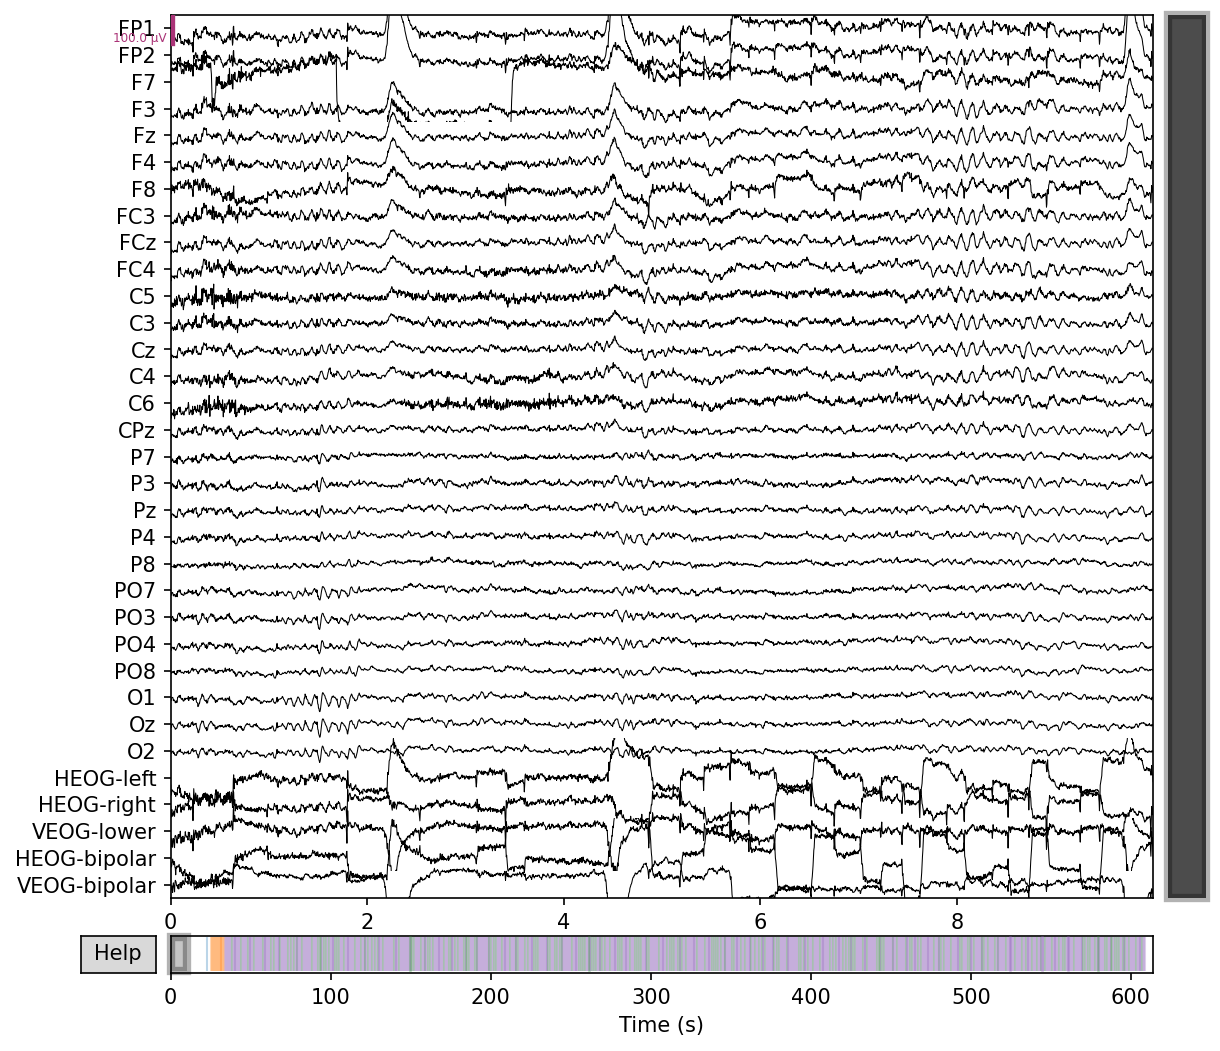

Channels marked as bad:
none
Channels marked as bad:
none


In [11]:
# Time domain analysis of Raw
raw.plot(scalings={'eeg': 50e-6},butterfly=False, n_channels=len(raw.ch_names),duration=10 )

In [12]:
# Frequency Domain (Power Spectrum Domain) of raw
# raw.compute_psd().plot(average=True,picks=['Pz','Cz']);
raw.compute_psd().plot(average=True);

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


### Preprocessing

In [ ]:
# Filtering - Bandpass and Notch filter
raw_filtered = raw.copy()
raw_filtered.filter(
        l_freq=Config.HIGH_PASS, 
        h_freq=Config.LOW_PASS, 
        fir_design='firwin'
    )
raw_filtered.notch_filter(freqs=Config.NOTCH_FREQ, fir_design='firwin')
print(f"Applied {Config.HIGH_PASS}-{Config.LOW_PASS} Hz bandpass and {Config.NOTCH_FREQ} Hz notch filters")



In [68]:
raw_filtered.plot(duration=600)

In [140]:
raw_filtered.compute_psd().plot(average=True, show=True,picks=['Pz','Cz']);

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


## Extract Events and Create Epochs

In [13]:

# events,event_ids, stimulus_counts = extract_events(df)
events,event_ids,stimulus_count = extract_events(raw=raw)
Config.EPOCH_TMAX = 0.8
Config.EPOCH_TMIN = -0.2
Config.BASELINE = (-0.2,0)
Config.EVENT_DICT = event_ids
epochs = create_epochs(raw, events,Config)

=== EXTRACTING EVENTS ===

Found 1001 annotations:
  180: 15 occurrences
  70: 200 occurrences
  80: 785 occurrences
  1: 1 occurrences
Used Annotations descriptions: [np.str_('1'), np.str_('180'), np.str_('70'), np.str_('80')]
=== CREATING EPOCHS ===
Not setting metadata
1001 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1001 events and 257 original time points ...
0 bad epochs dropped
1: 1
180: 15
70: 200
80: 785
Created epochs - 1: 1, 180: 15, 70: 200, 80: 785


In [14]:
bin_1_idx, bin_2_idx = create_bins(events)
print(f"Bin 1 (Deviant preceded by Standard) trials: {len(bin_1_idx)}")
print(f"Bin 2 (Standard preceded by Standard) trials: {len(bin_2_idx)}")
epochs_bin1 = epochs[bin_1_idx]  # Deviant preceded by standard
epochs_bin2 = epochs[bin_2_idx]
print(len(epochs_bin2))  # Standard preceded by standard

Bin 1 (Deviant preceded by Standard) trials: 200
Bin 2 (Standard preceded by Standard) trials: 584
584


In [15]:
epoch_lists = [epochs]
time_window=(-0.1, 0.6)
sme_results = compute_sme_erplab(epoch_lists,time_window)

# Display SME results for channel quality assessment (especially C5 and F8)
for bin_name, results in sme_results.items():
    print(f"\n{bin_name} SME Results:")
    print(f"Number of epochs: {results['n_epochs']}")
    
    # Find channels of interest
    ch_names = results['channel_names']
    sme_vals = results['sme_values']
    for ch_idx, ch_name in enumerate(ch_names):
       print(f"  {ch_name}: SME = {sme_vals[ch_idx]}")
    
    # Show channels with highest SME (worst quality)
    worst_channels = np.argsort(sme_vals)[-5:]  # Top 5 worst
    print(f"  Channels with highest SME (consider for interpolation):")
    for idx in worst_channels:
        print(f"    {ch_names[idx]}: {sme_vals[idx]:.4f}")



Bin_1 SME Results:
Number of epochs: 1001
  FP1: SME = 1.0180228262492336e-06
  FP2: SME = 9.683732640046145e-07
  F7: SME = 6.389352840947873e-07
  F3: SME = 4.3136666775226776e-07
  Fz: SME = 4.003464284468016e-07
  F4: SME = 4.1649215666795534e-07
  F8: SME = 5.531300930135855e-07
  FC3: SME = 3.5450368491305967e-07
  FCz: SME = 3.2600488777911025e-07
  FC4: SME = 3.2131052464157346e-07
  C5: SME = 2.6863564676709494e-07
  C3: SME = 2.5990170558516804e-07
  Cz: SME = 2.6648257883063356e-07
  C4: SME = 2.9840423142713925e-07
  C6: SME = 2.1872684149839162e-07
  CPz: SME = 2.1465673997319387e-07
  P7: SME = 1.5573372147412566e-07
  P3: SME = 2.0901454964001405e-07
  Pz: SME = 1.9927547967785625e-07
  P4: SME = 1.7373870497620492e-07
  P8: SME = 1.5956311975984863e-07
  PO7: SME = 1.712337411137618e-07
  PO3: SME = 1.7734750030873757e-07
  PO4: SME = 2.9389698861069915e-07
  PO8: SME = 1.3629095445351261e-07
  O1: SME = 1.7208906879011814e-07
  Oz: SME = 1.643841513166829e-07
  O2: SM

In [16]:
bin1_sme = sme_results['Bin_1']['sme_values']
ch_names = sme_results['Bin_1']['channel_names']

# Create heatmap data (reshape SME values for visualization)
sme_matrix = bin1_sme.reshape(1, -1)

# Create color heatmap
plt.figure(figsize=(15, 3))
sns.heatmap(sme_matrix, 
           xticklabels=ch_names, 
           yticklabels=['SME'],
           annot=True, 
           fmt='.3f',
           cmap='Reds',  # Color scale - higher values = redder
           cbar_kws={'label': 'SME Value'})

plt.title('SME Values - Bin 1 (125-225ms) - Color Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print channels that "pop out" (highest SME values)
high_sme_idx = np.argsort(bin1_sme)[-8:]  # Top 8 worst channels
print("Channels that 'pop out' (highest SME):")
for idx in high_sme_idx:
   print(f"  {ch_names[idx]}: {bin1_sme[idx]:.4f}")

Channels that 'pop out' (highest SME):
  HEOG-left: 0.0000
  F8: 0.0000
  HEOG-bipolar: 0.0000
  VEOG-lower: 0.0000
  F7: 0.0000
  FP2: 0.0000
  FP1: 0.0000
  VEOG-bipolar: 0.0000


# Plot Channels with 2STD away

In [17]:
bin1_sme = sme_results['Bin_1']['sme_values']
ch_names = sme_results['Bin_1']['channel_names']

exclude_channels = ['HEOG-left', 'HEOG-right', 'VEOG-lower', 'HEOG-bipolar', 'VEOG-bipolar', 'FP1', 'FP2']
include_mask = [ch not in exclude_channels for ch in ch_names]

# Calculate outlier threshold using only "clean" channels
clean_sme_values = bin1_sme[include_mask]
mean_sme = np.mean(clean_sme_values)
std_sme = np.std(clean_sme_values)
outlier_threshold = mean_sme + 2 * std_sme  # 2 SDs above mean

# Identify outliers
outliers = bin1_sme > outlier_threshold

# Create visualization
plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(ch_names)), bin1_sme)

# Color outliers in red
for i, (bar, is_outlier) in enumerate(zip(bars, outliers)):
   if is_outlier:
       bar.set_color('red')
       bar.set_alpha(0.8)
   else:
       bar.set_color('lightblue')

# Add threshold line
plt.axhline(y=outlier_threshold, color='black', linestyle='--', 
           label=f'Outlier threshold (Mean + 2SD = {outlier_threshold:.3f})')

plt.xlabel('Channels')
plt.ylabel('SME Values')
plt.title('SME Outlier Detection - Channels >2 SDs from clean channel mean')
plt.xticks(range(len(ch_names)), ch_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print outlier analysis results
print(f"Mean SME (excluding blink channels): {mean_sme:.4f}")
print(f"Standard deviation: {std_sme:.4f}")
print(f"Outlier threshold (Mean + 2SD): {outlier_threshold:.4f}")
print(f"\nOutlier channels (>2 SDs above mean):")
for i, ch_name in enumerate(ch_names):
   if outliers[i]:
       print(f"  {ch_name}: {bin1_sme[i]:.4f} *** OUTLIER")

Mean SME (excluding blink channels): 0.0000
Standard deviation: 0.0000
Outlier threshold (Mean + 2SD): 0.0000

Outlier channels (>2 SDs above mean):
  FP1: 0.0000 *** OUTLIER
  FP2: 0.0000 *** OUTLIER
  F7: 0.0000 *** OUTLIER
  F8: 0.0000 *** OUTLIER
  VEOG-lower: 0.0000 *** OUTLIER
  HEOG-bipolar: 0.0000 *** OUTLIER
  VEOG-bipolar: 0.0000 *** OUTLIER


### Plot Mean ERP with STD Shaded Area

In [18]:

channel_name = 'Pz'
epochs_data = epochs.get_data(picks=channel_name)
mean_erp = epochs_data.mean(axis=0).squeeze()
std_erp = epochs_data.std(axis=0).squeeze()
times = epochs.times
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(times, mean_erp * 1e6, color='b', label='Mean ERP') # Convert to microvolts
ax.fill_between(times, (mean_erp - std_erp) * 1e6, (mean_erp + std_erp) * 1e6,
                color='b', alpha=0.2, label='Standard Deviation')
ax.axvline(0, color='r', linestyle='--', label='Stimulus Onset')
ax.axhline(0, color='k', linestyle='-')
ax.set_xlabel('Time (s)')
ax.set_ylabel(f'Amplitude ({channel_name}, μV)')
ax.set_title(f'Mean ERP with STD Shaded Area for {channel_name}')
ax.legend()
plt.show()

# Individual Trial with mean

In [19]:
# Get data for the specific channel and event
epochs_data = epochs.get_data(picks=channel_name)
times = epochs.times
fig, ax = plt.subplots(figsize=(8, 5))
for trial in epochs_data:
    ax.plot(times, trial.squeeze() * 1e6, color='black', alpha=0.3, linewidth=0.5)
mean_erp = epochs_data.mean(axis=0).squeeze()
ax.plot(times, mean_erp * 1e6, color='b', linewidth=2, label='Mean ERP')
ax.axvline(0, color='r', linestyle='--', label='Stimulus Onset')
ax.set_xlabel('Time (s)')
ax.set_ylabel(f'Amplitude ({channel_name}, μV)')
ax.set_title(f'Individual Trials and Mean ERP for {channel_name}')
ax.legend()
plt.show()

In [25]:
# Events of epochs
epochs.event_id

{'standard': 1, 'deviant': 2}

In [21]:
# epochs.plot()

In [ ]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw_filtered.info['sfreq'],  
                    event_id=epochs.event_id,                    
                    axes=ax)
plt.show()

# Visualize Average ERP Across Conditions of Interest – Before Artifact Correction

In [24]:
epochs.plot_image(picks=['Pz','Cz']);

Not setting metadata
1001 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1001 matching events found
No baseline correction applied
0 projection items activated


In [145]:
epochs.average().detrend().plot_joint(picks=['Pz','Cz']);

No projector specified for this dataset. Please consider the method self.add_proj.


#### Preclean data for ICA using AutoReject

In [146]:
ar = AutoReject(n_interpolate=[1, 2], # interpolate 1 or 2 channels only
                random_state=42,
                picks=mne.pick_types(epochs.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)
reject_log = ar.get_reject_log(epochs)

In [147]:
ar.__dict__
# 'n_interpolate': This tells you that AutoReject was configured to test interpolating (filling in) one or two bad channels at a time.
# 'n_interpolate_': The optimal setting it found for your EEG data was to interpolate just one/n channel. 
#   -- Interpolation is a technique where the values of a bad channel are estimated and replaced using the data from neighboring, good channels.
# 'consensus': AutoReject tested different consensus values, which represent the percentage of channels in an EEG epoch (a small segment of data) that must be bad to consider the entire epoch as "bad" and reject it
# 'consensus_': The best consensus value it found for your data 
# 'thresh_method':  algorithm used to find the best settings (like n_interpolate and consensus). It's a smart way to search through different combinations to find the ones that result in the cleanest data.
# 'threshes_': This is one of the most important parts of the output. These are the local rejection thresholds for each individual EEG channel.  AutoReject calculated a unique threshold for each channel (like 'Fz', 'C3', etc.) to determine if a signal within that specific channel is too noisy or "bad." A higher threshold means the channel can tolerate more noise before being marked as bad.
# 'cv': This stands for cross-validation. The data was split into 10 different folds to ensure that the chosen settings work well across the entire dataset, not just on a small part of it. This helps prevent overfitting.
# 'verbose':
# 'picks': It's the list of channel indices you provide to the AutoReject object when you create it or when you call a function like fit. This tells the algorithm which specific channels from your dataset it should consider when performing the artifact rejection.
# 'picks_': It is the learned or internal attribute of the fitted AutoReject object. It stores the final list of channel indices that the algorithm actually used for its computations. In most cases, picks_ will be identical to picks, confirming that the model used the channels you specified. However, in more complex scenarios, if AutoReject has to adjust the channel list (e.g., if you gave it a list of channel types like 'eeg' and it internally mapped those to indices), picks_ would reflect the final, definite list of channels that were processed. It acts as a record of the channels the model was trained on.
# 'n_jobs': This means AutoReject used all available CPU cores to speed up the processing.
# 'random_state': This is a seed for the random number generator, ensuring that if you run the same code again, you'll get the exact same results.
# 'cv_': This is the cross-validation object used during the fitting process. It's an instance of KFold, a class from the scikit-learn library. KFold(n_splits=10, random_state=None, shuffle=False) means the data was split into 10 distinct parts (folds). AutoReject used 9 of these parts to "train" and find the best parameters, and the remaining 1 part to "test" and see how well those parameters performed. It repeated this process 10 times, so each part got a turn at being the test set. This ensures the chosen parameters are robust and not just a good fit for one specific part of your data.
# 'dots': This parameter would hold information about the locations of the EEG electrodes if it were provided during the fitting process. Since it's None, it means the electrode locations weren't explicitly given to AutoReject, and it performed the calculations without that spatial information.
# 'loss_': This large, nested array represents the loss values for the different combinations of n_interpolate and consensus that were tested during the Bayesian optimization. Each number is a score indicating how well a particular combination of settings performed. A lower loss value means better performance. The inf (infinity) values likely indicate combinations that were not tested because they were considered non-optimal from the beginning.
# 'local_reject_': This final part shows the best-performing AutoReject model. It confirms the optimal settings that the fit method found: consensus=0.1 (which is slightly different from the consensus_ value, because this one refers to the local rejection step), and n_interpolate=0 (which means it’s not interpolating channels at this stage, but rather using the global n_interpolate_ for the final clean data).

{'n_interpolate': [1, 2],
 'consensus': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'thresh_method': 'bayesian_optimization',
 'cv': 10,
 'verbose': False,
 'picks': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'n_jobs': -1,
 'random_state': 42,
 'picks_': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'cv_': KFold(n_splits=10, random_state=None, shuffle=False),
 'dots': None,
 'n_interpolate_': {'eeg': 2},
 'consensus_': {'eeg': np.float64(0.7000000000000001)},
 'threshes_': {'Fz': np.float64(6.788578565740298e-05),
  'C3': np.float64(0.0004918572069786741),
  'Cz': np.float64(0.00016408233412001724),
  'C4': np.float64(0.00034812171056563445),
  'Pz': np.float64(0.00033542723216886856),
  'PO7': np.float64(0.0015987367022272153),
  'Oz': np.float64(0.0006710558762351387),
  'PO8': np.float64(0.0014812724918368005)},
 'loss_': {'eeg': array([[[           inf,            inf,            inf,            inf,
                      inf,            inf,            inf,            inf,
       

---

### Step 1. Compute candidate thresholds

For one channel:

* For each epoch → compute **ptp = max – min amplitude**.
* Collect all those ptp values → this gives a **sorted list of candidate thresholds** (from least noisy to most noisy).

So if you had 100 epochs, you now have 100 possible threshold candidates.

---

### Step 2. Evaluate thresholds

For each candidate threshold:

* Mark epochs as **good** if ptp ≤ threshold, **bad** otherwise.
* Keep only the "good" ones and compute cross-validation performance (e.g., how stable the averaged signal looks across folds).

---

### Step 3. Choose the best threshold

* If using **Random Search**: test a random subset of thresholds.
* If using **Bayesian Optimization**: test smarter candidates iteratively to converge faster.

The threshold that gives the **best cross-validation performance** is selected.

---

 Autoreject **doesn’t directly set threshold per epoch**. Instead, it evaluates **candidate thresholds** (derived from epoch ptp values) and finds the **one global threshold for that channel** that works best across all epochs via cross-validation.

---

### Step 4: Consensus and Interpolation

These two (`consensus_` and `n_interpolate_`) are the *core hyperparameters* of **global autoreject** (when you fit it across multiple channels). 

---

### 🔹 1. `n_interpolate_`

* **Meaning**: how many sensors to interpolate when an epoch is marked bad.

  * If `n_interpolate = 1`, replace the worst channel in the epoch.
  * If `n_interpolate = 2`, replace the 2 worst channels, etc.
* **How estimated**:

  * `_run_local_reject_cv` loops over candidate values of `n_interpolate` (e.g. 1, 2, …).
  * For each, it interpolates that many bad channels in each epoch.
  * Then computes cross-validated **loss** (same stability score as we discussed).
  * The value minimizing CV loss is chosen → `n_interpolate_[ch_type]`.

---

### 🔹 2. `consensus_`

* **Meaning**: what fraction of sensors need to agree that an epoch is bad before discarding it.

  * Example: If `consensus = 0.3` and you have 64 channels → at least 19 channels must flag epoch as bad to reject it.
* **How estimated**:

  * `_run_local_reject_cv` also loops over candidate `consensus` values (a grid of fractions).
  * For each `consensus`, it marks epochs as bad if enough channels exceed their individual thresholds.
  * Again, CV loss is computed.
  * The best value becomes `consensus_[ch_type]`.

---

### 🔹 3. Joint tuning

`_run_local_reject_cv` actually runs a **grid search** over `(consensus, n_interpolate)` pairs with CV.

* Loss is stored in a 3D array: `loss[consensus_idx, n_interp_idx, fold]`.
* The best pair is picked per channel type (`ch_type`) and stored in the fitted `AutoReject` object.

---

### 🔹 Intuition

* `n_interpolate_` balances *repairing vs. discarding* bad channels in an epoch.
* `consensus_` balances *sensitivity vs. robustness* to noise across sensors.
* Cross-validation ensures you’re picking the pair that yields the most **stable average ERP** without over-rejecting or under-rejecting.

---

**TLDR**:

* `n_interpolate_` = optimal number of bad sensors to interpolate (instead of dropping the epoch).
* `consensus_` = optimal fraction of sensors that must vote “bad” to throw away an epoch.
  Both are found via **cross-validation grid search** that minimizes epoch-to-mean instability.

---


### Visualize Interpolated and Bad epochs

In [123]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto');
# plt.show()


# Visualize bad sensors/channel per trials

In [ ]:
# 
scalings = dict(eeg=40e-6)
reject_log.plot_epochs(epochs, scalings=scalings)

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


### Fit ICA to data

In [148]:

# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run; The value 42 is used by convention, because it is the “Answer to the Ultimate Question of Life, the Universe, and Everything” in The Hitchhiker’s Guide to the Galaxy
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA( n_components=ica_n_components,
                            random_state=random_state)

# In the ica.fit() function call, we pass the epochs data but, critically, we include the selector [~reject_log] to exclude the epochs that were marked as bad by AutoReject (~ means “not”).
ica.fit(epochs[~reject_log.bad_epochs])

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 3 components


C:\Users\Keerti\AppData\Local\Temp\ipykernel_33416\2519130980.py:10: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs[~reject_log.bad_epochs])


Fitting ICA took 0.7s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,18 iterations on epochs (131824 samples)
ICA components,3
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


# Visualize ICA Component

In [149]:
ica.plot_sources(epochs[~reject_log.bad_epochs], show_scrollbars=False, show=True);

Not setting metadata
749 matching events found
No baseline correction applied
0 projection items activated


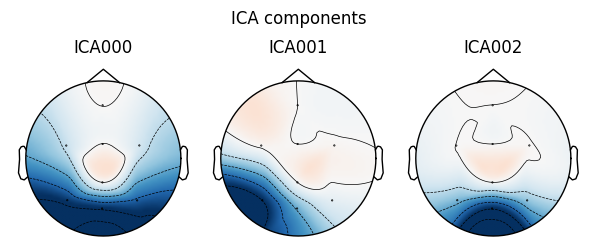

In [150]:
ica.plot_components()

In [151]:
ica.plot_properties(epochs, picks=range(0, ica.n_components_))
# , psd_args={'fmax': Config.HIGH_PASS}
# https://labeling.ucsd.edu/tutorial/labels
# https://mne.tools/mne-icalabel/stable/generated/examples/00_iclabel.html#fitting-and-plotting-the-ica-solution

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

### Identifying and excluding artifact using ICALABEL


In [152]:
from mne_icalabel import label_components
ic_labels = label_components(epochs[~reject_log.bad_epochs], ica, method="iclabel")
labels = ic_labels["labels"]
exclude_idx = [
    idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
]
print(labels)
print(f"Excluding these ICA components: {exclude_idx}")

C:\Users\Keerti\AppData\Local\Temp\ipykernel_33416\3726066196.py:2: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs[~reject_log.bad_epochs], ica, method="iclabel")
C:\Users\Keerti\AppData\Local\Temp\ipykernel_33416\3726066196.py:2: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs[~reject_log.bad_epochs], ica, method="iclabel")
C:\Users\Keerti\AppData\Local\Temp\ipykernel_33416\3726066196.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was desig

['brain', 'brain', 'brain']
Excluding these ICA components: []


In [ ]:
epochs_raw = epochs.copy()
epochs_postica = ica.apply(epochs_raw, exclude=exclude_idx)

epochs_postica.plot();

Applying ICA to Epochs instance
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


C:\Users\Keerti\AppData\Local\Temp\ipykernel_33416\3698717886.py:2: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_postica = ica.apply(epochs_raw, exclude=exclude_idx)


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [154]:
epochs_postica

<Epochs | 1000 events (all good), -0.1 – 0.6 s (baseline -0.1 – 0 s), ~10.8 MiB, data loaded,
 'standard': 757
 'deviant': 243>

In [155]:
epochs_clean, reject_log_clean = ar.transform(epochs_postica, return_log=True)
epochs_clean.plot()

Dropped 251 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 22, 23, 24, 25, 27, 30, 31, 32, 33, 36, 45, 179, 193, 234, 252, 253, 254, 256, 264, 277, 278, 291, 299, 300, 308, 311, 313, 314, 320, 330, 336, 342, 349, 351, 355, 356, 357, 358, 363, 366, 367, 369, 373, 381, 382, 387, 392, 396, 397, 398, 400, 401, 404, 405, 408, 412, 415, 416, 419, 423, 425, 432, 434, 435, 443, 456, 461, 465, 471, 472, 473, 477, 478, 485, 489, 493, 494, 495, 500, 503, 506, 507, 508, 509, 515, 517, 521, 527, 528, 529, 530, 531, 533, 534, 539, 541, 546, 547, 548, 549, 552, 553, 554, 561, 562, 566, 591, 600, 601, 602, 614, 615, 616, 627, 628, 639, 645, 646, 650, 651, 653, 654, 658, 666, 667, 687, 691, 692, 699, 702, 704, 706, 710, 712, 713, 714, 718, 719, 720, 721, 722, 723, 724, 725, 726, 728, 729, 730, 731, 732, 733, 734, 736, 738, 743, 744, 748, 749, 750, 751, 757, 766, 774, 779, 789, 795, 796, 798, 799, 808, 809, 818, 822, 823, 825, 829, 831, 832, 837, 840, 841, 842, 843, 844, 845, 846,

No projector specified for this dataset. Please consider the method self.add_proj.


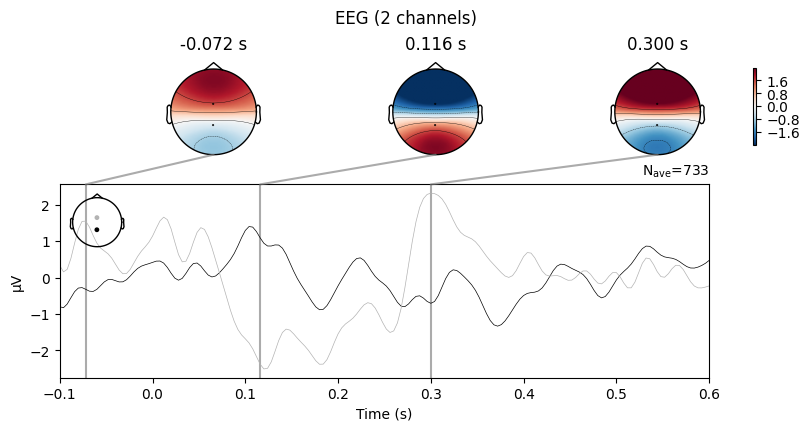

In [101]:
epochs_clean.average().detrend().plot_joint(picks=['Pz','Cz'])

In [156]:

channel_name = 'Pz'
epochs_data = epochs_clean.get_data(picks=channel_name)
mean_erp = epochs_data.mean(axis=0).squeeze()
std_erp = epochs_data.std(axis=0).squeeze()
times = epochs_clean.times
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(times, mean_erp * 1e6, color='b', label='Mean ERP') # Convert to microvolts
ax.fill_between(times, (mean_erp - std_erp) * 1e6, (mean_erp + std_erp) * 1e6,
                color='b', alpha=0.2, label='Standard Deviation')
ax.axvline(0, color='r', linestyle='--', label='Stimulus Onset')
ax.axhline(0, color='k', linestyle='-')
ax.set_xlabel('Time (s)')
ax.set_ylabel(f'Amplitude ({channel_name}, μV)')
ax.set_title(f'Mean ERP with STD Shaded Area for {channel_name}')
ax.legend()
plt.show()

In [157]:
# Get data for the specific channel and event
epochs_data = epochs_clean.get_data(picks=channel_name)
times = epochs_clean.times
fig, ax = plt.subplots(figsize=(8, 5))
for trial in epochs_data:
    ax.plot(times, trial.squeeze() * 1e6, color='black', alpha=0.3, linewidth=0.5)
mean_erp = epochs_data.mean(axis=0).squeeze()
ax.plot(times, mean_erp * 1e6, color='b', linewidth=2, label='Mean ERP')
ax.axvline(0, color='r', linestyle='--', label='Stimulus Onset')
ax.set_xlabel('Time (s)')
ax.set_ylabel(f'Amplitude ({channel_name}, μV)')
ax.set_title(f'Individual Trials and Mean ERP for {channel_name}')
ax.legend()
plt.show()

In [ ]:
# path = 'C:\Users\Keerti\Downloads\MySolution\EEG-ExPy\tests\Analysis\ica_data'
# ica.save('ica_data' + 'sub_1' + '-ica.fif', 
#         overwrite=True);